In [18]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import requests
import zipfile
import hashlib
import collections
from torch import nn
from torch.utils import data
import torch.nn.functional as F
from sklearn import metrics
import tarfile

In [19]:
# data copied from https://github.com/d2l-ai/d2l-en/blob/master/d2l/torch.py cause pip install d2l, do not work
def tokenize(lines, token='word'):
  """Split text lines into word or character tokens.
  Defined in :numref:`sec_utils`"""
  assert token in ('word', 'char'), 'Unknown token type: ' + token
  return [line.split() if token == 'word' else list(line) for line in lines]

class Vocab:
  """Vocabulary for text."""
  def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
    """Defined in :numref:`sec_text-sequence`"""
    if tokens and isinstance(tokens[0], list):
      tokens = [token for line in tokens for token in line]
    counter = collections.Counter(tokens)
    self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                              reverse=True)
    self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
        token for token, freq in self.token_freqs if freq >= min_freq])))
    self.token_to_idx = {token: idx
                         for idx, token in enumerate(self.idx_to_token)}

  def __len__(self):
    return len(self.idx_to_token)

  def __getitem__(self, tokens):
    if not isinstance(tokens, (list, tuple)):
      return self.token_to_idx.get(tokens, self.unk)
    return [self.__getitem__(token) for token in tokens]

  def to_tokens(self, indices):
    if hasattr(indices, '__len__') and len(indices) > 1:
      return [self.idx_to_token[int(index)] for index in indices]
    return self.idx_to_token[indices]

  @property
  def unk(self):
    return self.token_to_idx['<unk>']

def truncate_pad(line, num_steps, padding_token):
  """Truncate or pad sequences.
  Defined in :numref:`sec_utils`"""
  if len(line) > num_steps:
    return line[:num_steps]
  return line + [padding_token] * (num_steps - len(line))

class TokenEmbedding:
  """Token Embedding."""
  def __init__(self, embedding_name):
    """Defined in :numref:`sec_synonyms`"""
    self.idx_to_token, self.idx_to_vec = self._load_embedding(
        embedding_name)
    self.unknown_idx = 0
    self.token_to_idx = {token: idx for idx, token in
                         enumerate(self.idx_to_token)}

  def _load_embedding(self, embedding_name):
    idx_to_token, idx_to_vec = ['<unk>'], []
    data_dir = download_extract(embedding_name)
    with open(os.path.join(data_dir, 'vec.txt'), 'r') as f:
      for line in f:
        elems = line.rstrip().split(' ')
        token, elems = elems[0], [float(elem) for elem in elems[1:]]
        if len(elems) > 1:
          idx_to_token.append(token)
          idx_to_vec.append(elems)
    idx_to_vec = [[0] * len(idx_to_vec[0])] + idx_to_vec
    return idx_to_token, torch.tensor(idx_to_vec)

  def __getitem__(self, tokens):
    indices = [self.token_to_idx.get(token, self.unknown_idx)
               for token in tokens]
    vecs = self.idx_to_vec[torch.tensor(indices)]
    return vecs

  def __len__(self):
    return len(self.idx_to_token)

def download_extract(name, folder=None):
  """Download and extract a zip/tar file.
  Defined in :numref:`sec_utils`"""
  fname = download(name)
  base_dir = os.path.dirname(fname)
  data_dir, ext = os.path.splitext(fname)
  if ext == '.zip':
    fp = zipfile.ZipFile(fname, 'r')
  elif ext in ('.tar', '.gz'):
    fp = tarfile.open(fname, 'r')
  else:
    assert False, 'Only zip/tar files can be extracted.'
  fp.extractall(base_dir)
  return os.path.join(base_dir, folder) if folder else data_dir

def download(url, folder='./data', sha1_hash=None):
  """Download a file to folder and return the local filepath.
  Defined in :numref:`sec_utils`"""
  if not url.startswith('http'):
    url, sha1_hash = {'glove.6b.50d': ('http://d2l-data.s3-accelerate.amazonaws.com/' + 'glove.6B.50d.zip', '0b8703943ccdb6eb788e6f091b8946e82231bc4d'),
                      'glove.6b.100d': ('http://d2l-data.s3-accelerate.amazonaws.com/' + 'glove.6B.100d.zip', 'cd43bfb07e44e6f27cbcc7bc9ae3d80284fdaf5a') }[url]
  os.makedirs(folder, exist_ok=True)
  fname = os.path.join(folder, url.split('/')[-1])
  if os.path.exists(fname) and sha1_hash:
    sha1 = hashlib.sha1()
    with open(fname, 'rb') as f:
      while True:
        data = f.read(1048576)
        if not data:
          break
        sha1.update(data)
    if sha1.hexdigest() == sha1_hash:
      return fname
  print(f'Downloading {fname} from {url}...')
  r = requests.get(url, stream=True, verify=True)
  with open(fname, 'wb') as f:
    f.write(r.content)
  return fname

In [20]:
def out_rating(x):
  if x <= 4:
    return 0
  elif x < 7:
    return 1
  else:
    return 2

def prepare_ds(ds, train_col = ['rating', 'effectiveness', 'sideEffects']):
  ds.rename(columns = {'Unnamed: 0': 'drugId', 'commentsReview': 'ratingReview', 'benefitsReview': 'effectivenessReview'}, errors='raise', inplace=True)
  conversions = {'sideEffects': 'category', 'effectiveness': 'category'}
  for k, v in conversions.items():
    ds[k] = train[k].astype(v)

  ds.dropna(subset=train_col, inplace=True)
  out_functions = {
      'rating': out_rating,
      'effectiveness': lambda x: {'Ineffective': 0, 'Marginally Effective': 1, 'Moderately Effective': 1, 'Considerably Effective': 2, 'Highly Effective': 2}.get(x),
      'sideEffects': lambda x: {'No Side Effects': 0, 'Mild Side Effects': 1, 'Moderate Side Effects': 1, 'Severe Side Effects': 2, 'Extremely Severe Side Effects': 2}.get(x)
    }
  for tc in train_col:
    ds[f'{tc}_out'] = ds.apply(lambda x: out_functions[tc](x[tc]), axis=1).astype('int64')

train = pd.read_csv('/Users/yarik/Downloads/drugLib_raw/drugLibTrain_raw.tsv', sep='\t', header=0)
prepare_ds(train)
train.head()

,drugId,urlDrugName,rating,effectiveness,sideEffects,condition,effectivenessReview,sideEffectsReview,ratingReview,rating_out,effectiveness_out,sideEffects_out
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ...",0,2,1
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest...",0,2,2
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...,2,2,0
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...,0,1,1
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above,0,1,2


In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3107 entries, 0 to 3106
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   drugId               3107 non-null   int64   
 1   urlDrugName          3107 non-null   object  
 2   rating               3107 non-null   int64   
 3   effectiveness        3107 non-null   category
 4   sideEffects          3107 non-null   category
 5   condition            3106 non-null   object  
 6   effectivenessReview  3107 non-null   object  
 7   sideEffectsReview    3105 non-null   object  
 8   ratingReview         3099 non-null   object  
 9   rating_out           3107 non-null   int64   
 10  effectiveness_out    3107 non-null   int64   
 11  sideEffects_out      3107 non-null   int64   
dtypes: category(2), int64(5), object(5)
memory usage: 249.3+ KB


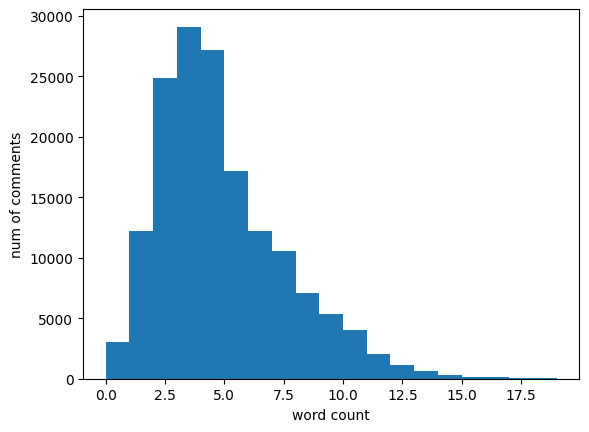

In [22]:
train = train.dropna(subset=['ratingReview'])

plt.hist([len(tokens) for _, x in train.iterrows() for tokens in x['ratingReview'].split(' ')], bins=range(0, 20))
plt.xlabel('word count')
plt.ylabel('num of comments')
plt.show()

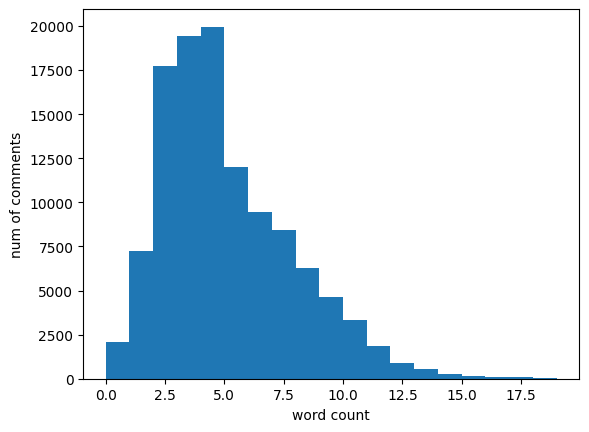

In [23]:
train = train.dropna(subset=['effectivenessReview'])

plt.hist([len(tokens) for _, x in train.iterrows() for tokens in x['effectivenessReview'].split(' ')], bins=range(0, 20))
plt.xlabel('word count')
plt.ylabel('num of comments')
plt.show()

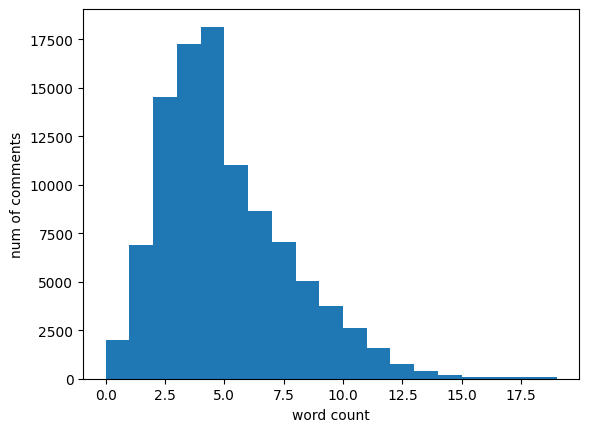

In [24]:
train = train.dropna(subset=['sideEffectsReview'])

plt.hist([len(tokens) for _, x in train.iterrows() for tokens in x['sideEffectsReview'].split(' ')], bins=range(0, 20))
plt.xlabel('word count')
plt.ylabel('num of comments')
plt.show()

In [25]:
def load_dataset(batch_size, col, trim_len = 15):
  assert col in ('rating', 'effectiveness', 'sideEffects')

  review_col, out_col = f'{col}Review', f'{col}_out'

  train = pd.read_csv('/Users/yarik/Downloads/drugLib_raw/drugLibTrain_raw.tsv', sep='\t', header=0)
  prepare_ds(train)
  test = pd.read_csv('/Users/yarik/Downloads/drugLib_raw/drugLibTrain_raw.tsv', sep='\t', header=0)
  prepare_ds(test)

  train = train.dropna(subset=[review_col])
  test = test.dropna(subset=[review_col])

  train_tokens = tokenize(train[review_col].tolist(), token='word')
  test_tokens = tokenize(test[review_col].tolist(), token='word')

  vocab = Vocab(train_tokens, min_freq=5)

  train_y_tensor = torch.tensor(train[out_col].tolist())
  test_y_tensor = torch.tensor(test[out_col].tolist())

  train_features = torch.tensor([truncate_pad(vocab[line], trim_len, vocab['<pad>']) for line in train_tokens])
  test_features = torch.tensor([truncate_pad(vocab[line], trim_len, vocab['<pad>']) for line in test_tokens])

  train_dataset = data.TensorDataset(train_features, F.one_hot(train_y_tensor, 3))
  test_dataset = data.TensorDataset(test_features, F.one_hot(test_y_tensor, 3))
  train_iter = data.DataLoader(train_dataset, batch_size, shuffle=True)
  test_iter = data.DataLoader(test_dataset, batch_size, shuffle=False)
  return train_iter, test_iter, vocab

Configuring RNN

In [26]:
class RNNModel(nn.Module):
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout_prob = 0.25, num_intermid_neutrons = 128, encoder_ctor = nn.RNN, **kwargs):
    super(RNNModel, self).__init__(**kwargs)
    self.num_hiddens = num_hiddens
    self.num_layers = num_layers
    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.encoder = encoder_ctor(embed_size, num_hiddens, num_layers=num_layers, bidirectional=True, dropout=dropout_prob)

    decoders = []
    if num_intermid_neutrons is None:
      decoders = [nn.Linear(4*num_hiddens, 3)]
    else:
      if not isinstance(num_intermid_neutrons, list):
        num_intermid_neutrons = [num_intermid_neutrons]

      decoders.append(nn.Linear(4*num_hiddens, num_intermid_neutrons[0]))
      decoders.append(nn.ReLU())
      for i, n in enumerate(num_intermid_neutrons[1:]):
        decoders.append(nn.Linear(num_intermid_neutrons[i-2], n))
        decoders.append(nn.ReLU())
      decoders.append(nn.Linear(num_intermid_neutrons[-1], 3))
    self.fc = nn.Sequential(*decoders)

  def forward(self, inputs):
    embeddings = self.embedding(inputs.T.long())

    self.encoder.flatten_parameters()
    out, _ = self.encoder(embeddings)
    output = torch.cat([out[0], out[-1]], dim=1)

    return self.fc(output)

Configuring GloVe

In [27]:
glove_embedding = TokenEmbedding('glove.6b.100d')

In [28]:
def train_model(model, train_iter, test_iter, trainer, loss, num_epochs, device='cpu'):
  training_losses = []
  test_losses = []
  training_accuracies = []
  test_accuracies = []
  num_batches = len(train_iter)
  for epoch in range(num_epochs):
    print(f'started epoch {epoch+1}/{num_epochs}')
    batch_losses = []
    model.train()
    correct = 0
    for i, (X, y) in enumerate(train_iter):
      X = X.to(device)
      y = y.to(device)
      trainer.zero_grad()
      y_pred = model(X)
      l = loss(y_pred, y.float())
      batch_losses.append(l.item())
      l.backward()
      trainer.step()
      correct += (y_pred.argmax(1) == y.argmax(1)).float().sum().item()
      if (i+1)%20 == 0:
        print(f'\tbatch {i+1}/{num_batches}, loss: {np.mean(batch_losses)}')
    training_losses.append(np.mean(batch_losses))
    training_accuracies.append(100*correct/len(train_iter.dataset))

    with torch.no_grad():
      batch_test_losses = []
      correct = 0
      for X, y in test_iter:
        X = X.to(device)
        y = y.to(device)
        model.eval()
        y_pred = model(y)
        l = loss(y_pred, y.float())
        batch_test_losses.append(l.item())
        correct += (y_pred.argmax(1) == y.argmax(1)).float().sum().item()
      test_losses.append(np.mean(batch_test_losses))
      test_accuracies.append(100*correct/len(test_iter.dataset))
    print(f'epoch {epoch+1}/{num_epochs}, train: {training_losses[-1]}, test: {test_losses[-1]}')
  return training_losses, test_losses, training_accuracies, test_accuracies

def visualize_learning(train_data, test_data, plot_type):
  plt.plot(train_data, label=f'training {plot_type}')
  plt.plot(test_data, label=f'test {plot_type}')
  plt.legend(loc='upper left')
  plt.show()

def gather_metrics(y_true, y_pred, average='micro'):
  metrics_dict = {}
  metrics_dict['balanced_accuracy'] = metrics.balanced_accuracy_score(y_true.argmax(1), y_pred.argmax(1))
  metrics_dict['f1'] = metrics.f1_score(y_true.argmax(1), y_pred.argmax(1), average=average)
  metrics_dict['roc_auc'] = metrics.roc_auc_score(y_true, y_pred, average=average)
  metrics_dict['precision'] = metrics.precision_score(y_true.argmax(1), y_pred.argmax(1), average=average)
  metrics_dict['recall'] = metrics.recall_score(y_true.argmax(1), y_pred.argmax(1), average=average)

  return metrics_dict

def train_metric_nn(train_iter, test_iter, vocab, encoder_ctor, embeds, embed_size=100, num_hiddens=50,
                    num_layers=2, num_intermid_neutrons=100, lr=0.01, num_epochs=10):
  net = RNNModel(vocab_size=len(vocab),
                 embed_size=embed_size,
                 num_hiddens=num_hiddens,
                 num_layers=num_layers,
                 num_intermid_neutrons=num_intermid_neutrons,
                 encoder_ctor=encoder_ctor)

  net.embedding.weight.data.copy_(embeds)
  net.embedding.weight.requires_grad = False

  trainer = torch.optim.Adam(net.parameters(), lr=lr)
  loss = nn.CrossEntropyLoss()

  a, b, c, d = train_model(net, train_iter, test_iter, trainer, loss, num_epochs)

  visualize_learning(a, b, 'loss')
  visualize_learning(c, d, 'accuracy')

  X_test, y_test = test_iter.dataset.tensors

  y_pred = net(X_test)
  m = gather_metrics(y_test.detach().numpy(), y_pred.detach().numpy(), average=None)
  for k, v in m.items():
    print(f'{k.replace("_", " ")} score: {v}')

Overall rating

In [29]:
train_iter, test_iter, vocab = load_dataset(32, 'rating')

embeds = glove_embedding[vocab.idx_to_token]
embeds.shape

torch.Size([2717, 100])

RNN

started epoch 1/10
	batch 20/97, loss: 0.887782746553421
	batch 40/97, loss: 0.8866777703166008
	batch 60/97, loss: 0.8712238738934199
	batch 80/97, loss: 0.8653549566864968
epoch 1/10, train: 0.8628355203215609, test: 0.75559747434154
started epoch 2/10
	batch 20/97, loss: 0.8194938778877259
	batch 40/97, loss: 0.817041152715683
	batch 60/97, loss: 0.8123235881328583
	batch 80/97, loss: 0.8212623506784439
epoch 2/10, train: 0.8268238883657554, test: 0.8104718806817359
started epoch 3/10
	batch 20/97, loss: 0.8528680726885796
	batch 40/97, loss: 0.8509528838098049
	batch 60/97, loss: 0.8442476307352383
	batch 80/97, loss: 0.8315511759370565
epoch 3/10, train: 0.8316504399186557, test: 0.809781853685674
started epoch 4/10
	batch 20/97, loss: 0.8364021331071854
	batch 40/97, loss: 0.8286136195063591
	batch 60/97, loss: 0.8168467660744985
	batch 80/97, loss: 0.8289981491863727
epoch 4/10, train: 0.8212517518358132, test: 0.8344156858847314
started epoch 5/10
	batch 20/97, loss: 0.81227193

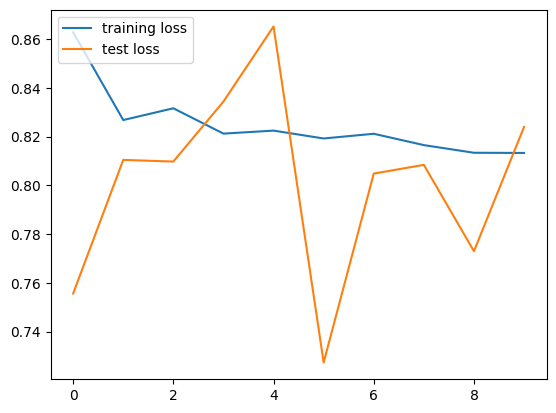

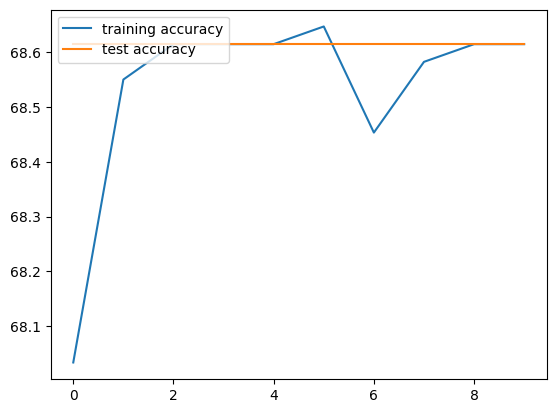

balanced accuracy score: 0.3333333333333333
f1 score: [0.         0.         0.81386442]
roc auc score: [0.50055643 0.5        0.49972113]
precision score: [0.         0.         0.68614789]
recall score: [0. 0. 1.]


/Users/yarik/Downloads/MachineLearning/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
train_metric_nn(train_iter, test_iter, vocab, nn.RNN, embeds)

GRU

started epoch 1/10
	batch 20/97, loss: 0.9464508950710296
	batch 40/97, loss: 0.8896999701857566
	batch 60/97, loss: 0.8836741745471954
	batch 80/97, loss: 0.8780621320009232
epoch 1/10, train: 0.8692138582160792, test: 0.8807503796115363
started epoch 2/10
	batch 20/97, loss: 0.8143274754285812
	batch 40/97, loss: 0.8236817121505737
	batch 60/97, loss: 0.8252686152855555
	batch 80/97, loss: 0.8206298500299454
epoch 2/10, train: 0.8150070567720944, test: 0.9040216588482415
started epoch 3/10
	batch 20/97, loss: 0.7685682773590088
	batch 40/97, loss: 0.7981188729405403
	batch 60/97, loss: 0.8010097006956737
	batch 80/97, loss: 0.8036854200065136
epoch 3/10, train: 0.8032289595948052, test: 0.9836370164586097
started epoch 4/10
	batch 20/97, loss: 0.8295634329319
	batch 40/97, loss: 0.7757699474692344
	batch 60/97, loss: 0.7742875128984451
	batch 80/97, loss: 0.7871018312871456
epoch 4/10, train: 0.7857824367346223, test: 0.9732402765873781
started epoch 5/10
	batch 20/97, loss: 0.730471

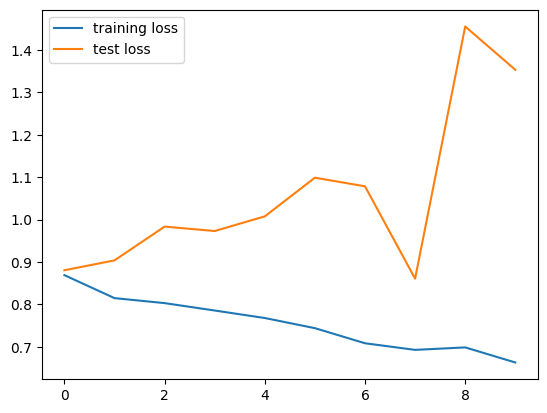

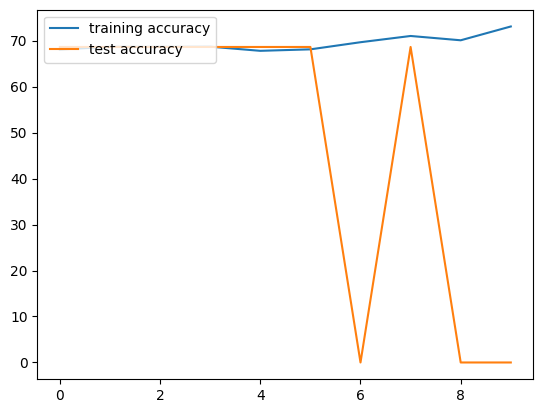

balanced accuracy score: 0.4607276773723188
f1 score: [0.5182266  0.0123839  0.85378913]
roc auc score: [0.87341586 0.79438282 0.88261002]
precision score: [0.73463687 0.25       0.75906261]
recall score: [0.40030441 0.00634921 0.97552941]


In [31]:
train_metric_nn(train_iter, test_iter, vocab, nn.GRU, embeds, num_hiddens=100)

LSTM

started epoch 1/10
	batch 20/97, loss: 0.9398848831653595
	batch 40/97, loss: 0.8697685822844505
	batch 60/97, loss: 0.8693018972873687
	batch 80/97, loss: 0.8637821733951568
epoch 1/10, train: 0.8587025428555676, test: 0.8270221358722019
started epoch 2/10
	batch 20/97, loss: 0.8208640217781067
	batch 40/97, loss: 0.8233258575201035
	batch 60/97, loss: 0.8297690113385519
	batch 80/97, loss: 0.8303532198071479
epoch 2/10, train: 0.8254571971819573, test: 0.8478400111198425
started epoch 3/10
	batch 20/97, loss: 0.8346276074647904
	batch 40/97, loss: 0.819835613667965
	batch 60/97, loss: 0.8143552909294764
	batch 80/97, loss: 0.8108316294848918
epoch 3/10, train: 0.8161420594785631, test: 0.8622930811852524
started epoch 4/10
	batch 20/97, loss: 0.7936791777610779
	batch 40/97, loss: 0.7991774722933769
	batch 60/97, loss: 0.8018468171358109
	batch 80/97, loss: 0.8092179700732232
epoch 4/10, train: 0.8120952807750899, test: 0.797835301492632
started epoch 5/10
	batch 20/97, loss: 0.83408

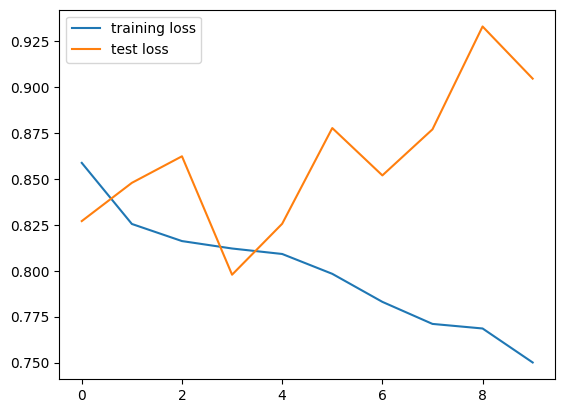

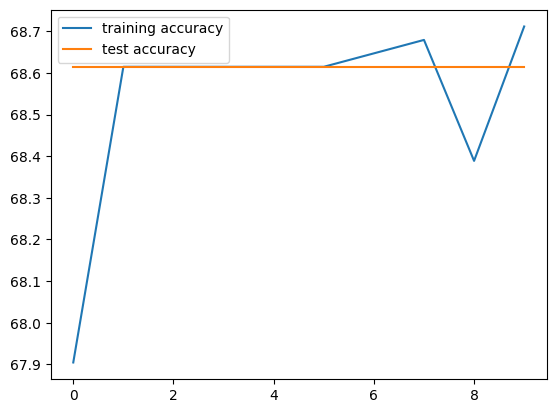

balanced accuracy score: 0.33536276002029425
f1 score: [0.01208459 0.         0.81464443]
roc auc score: [0.76134784 0.72174923 0.79632656]
precision score: [0.8        0.         0.68725744]
recall score: [0.00608828 0.         1.        ]


/Users/yarik/Downloads/MachineLearning/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
train_metric_nn(train_iter, test_iter, vocab, nn.LSTM, embeds, num_hiddens=100, num_layers=3, num_intermid_neutrons=128)

Predicting effectiveness

In [33]:
train_iter, test_iter, vocab = load_dataset(32, 'effectiveness', 10)

embeds = glove_embedding[vocab.idx_to_token]

RNN

started epoch 1/10
	batch 20/97, loss: 1.8836444050073624
	batch 40/97, loss: 1.3641551107168197
	batch 60/97, loss: 1.1947455753882725
	batch 80/97, loss: 1.0982194364070892
epoch 1/10, train: 1.0422667584468408, test: 0.6779535935097134
started epoch 2/10
	batch 20/97, loss: 0.7900702774524688
	batch 40/97, loss: 0.7761809088289737
	batch 60/97, loss: 0.7648821940024694
	batch 80/97, loss: 0.7648329675197602
epoch 2/10, train: 0.7710405680322155, test: 0.744527182628199
started epoch 3/10
	batch 20/97, loss: 1.147860237956047
	batch 40/97, loss: 0.9514754183590413
	batch 60/97, loss: 0.8971638962626457
	batch 80/97, loss: 1.1158036720007658
epoch 3/10, train: 1.0560868852531786, test: 0.7719629812486393
started epoch 4/10
	batch 20/97, loss: 0.7847139894962311
	batch 40/97, loss: 0.7569043666124344
	batch 60/97, loss: 0.7727287550767262
	batch 80/97, loss: 0.7717157624661922
epoch 4/10, train: 0.7701656793810657, test: 0.7078122561125412
started epoch 5/10
	batch 20/97, loss: 0.70503

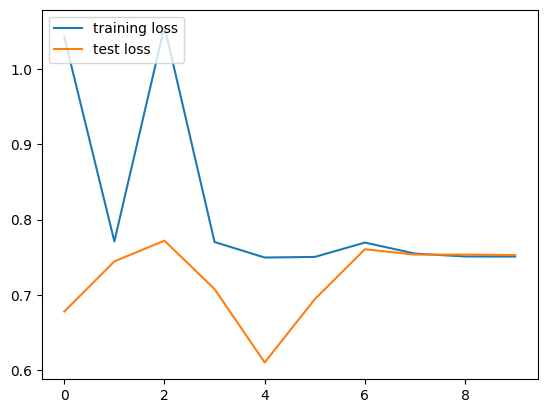

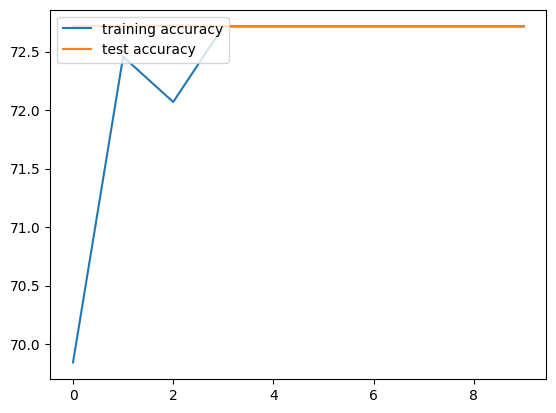

balanced accuracy score: 0.3333333333333333
f1 score: [0.         0.         0.84202655]
roc auc score: [0.50157839 0.50180144 0.50199822]
precision score: [0.         0.         0.72715531]
recall score: [0. 0. 1.]


/Users/yarik/Downloads/MachineLearning/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
train_metric_nn(train_iter, test_iter, vocab, nn.RNN, embeds, num_layers=2, num_hiddens=200, num_intermid_neutrons=256)

GRU

started epoch 1/13
	batch 20/97, loss: 0.8857508957386017
	batch 40/97, loss: 0.8222373023629188
	batch 60/97, loss: 0.7976749350627264
	batch 80/97, loss: 0.7761400934308768
epoch 1/13, train: 0.7560067975643984, test: 0.7557287873681059
started epoch 2/13
	batch 20/97, loss: 0.7012620478868484
	batch 40/97, loss: 0.6748612344264984
	batch 60/97, loss: 0.6771616856257121
	batch 80/97, loss: 0.6796030681580305
epoch 2/13, train: 0.6813348070862367, test: 0.7179767784384108
started epoch 3/13
	batch 20/97, loss: 0.6520884409546852
	batch 40/97, loss: 0.6618559658527374
	batch 60/97, loss: 0.655392886698246
	batch 80/97, loss: 0.647549083083868
epoch 3/13, train: 0.6404363724988761, test: 0.7870501968049511
started epoch 4/13
	batch 20/97, loss: 0.6041077151894569
	batch 40/97, loss: 0.6142729125916958
	batch 60/97, loss: 0.6097893143693606
	batch 80/97, loss: 0.603991062939167
epoch 4/13, train: 0.6033359564763984, test: 0.7511634101572725
started epoch 5/13
	batch 20/97, loss: 0.498109

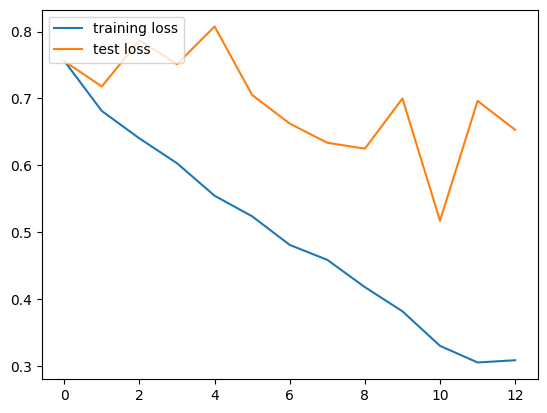

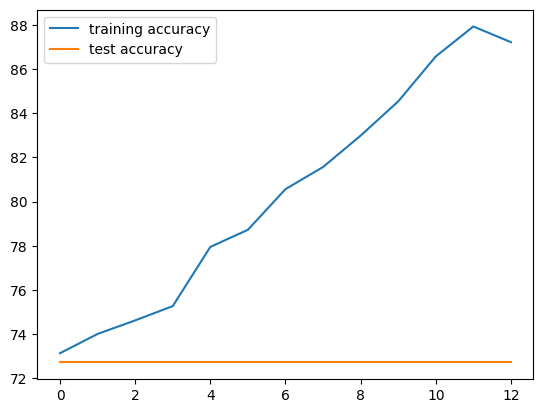

balanced accuracy score: 0.8697654170384609
f1 score: [0.82545455 0.80838894 0.95930359]
roc auc score: [0.99350392 0.95699598 0.97639547]
precision score: [0.74671053 0.94222222 0.94067435]
recall score: [0.92276423 0.70784641 0.97868561]


In [36]:
train_metric_nn(train_iter, test_iter, vocab, nn.GRU, embeds, num_hiddens=50, num_intermid_neutrons=128, num_epochs=13)

LSTM

started epoch 1/10
	batch 20/97, loss: 0.8034687787294388
	batch 40/97, loss: 0.7936526939272881
	batch 60/97, loss: 0.7909175942341486
	batch 80/97, loss: 0.7607358783483505
epoch 1/10, train: 0.7532854796070414, test: 0.7629487738781369
started epoch 2/10
	batch 20/97, loss: 0.7416024148464203
	batch 40/97, loss: 0.7346468433737755
	batch 60/97, loss: 0.7201098943750064
	batch 80/97, loss: 0.7135424558073282
epoch 2/10, train: 0.7050688650804696, test: 0.7812189379918206
started epoch 3/10
	batch 20/97, loss: 0.668405944108963
	batch 40/97, loss: 0.6767948120832443
	batch 60/97, loss: 0.6684323082367579
	batch 80/97, loss: 0.6649217456579208
epoch 3/10, train: 0.6751336879336957, test: 0.7734641171607775
started epoch 4/10
	batch 20/97, loss: 0.6200815051794052
	batch 40/97, loss: 0.6204945243895054
	batch 60/97, loss: 0.6267037317156792
	batch 80/97, loss: 0.6411240212619305
epoch 4/10, train: 0.6465879303892863, test: 0.7998168499199385
started epoch 5/10
	batch 20/97, loss: 0.6218

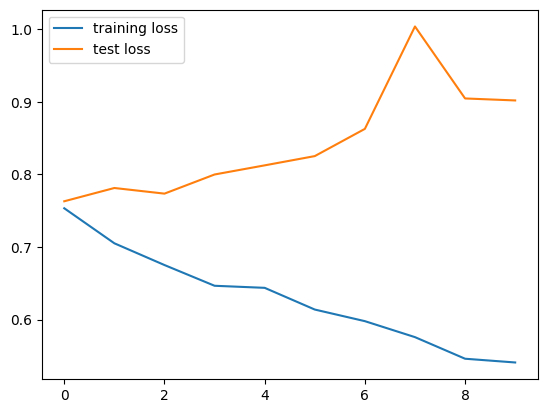

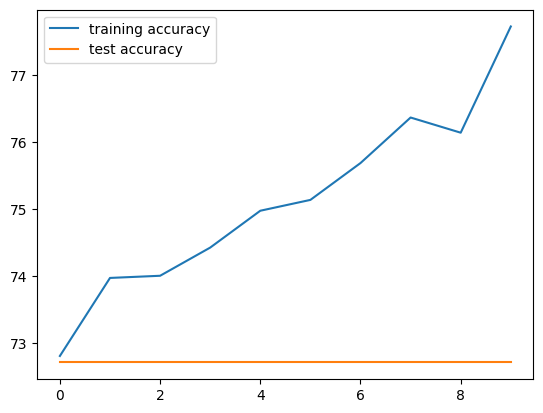

balanced accuracy score: 0.4145556389126934
f1 score: [0.         0.34065934 0.88050814]
roc auc score: [0.94953988 0.81026725 0.89661156]
precision score: [0.         0.49839228 0.79612347]
recall score: [0.         0.25876461 0.98490231]


/Users/yarik/Downloads/MachineLearning/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
train_metric_nn(train_iter, test_iter, vocab, nn.LSTM, embeds, num_hiddens=100, num_intermid_neutrons=[200, 64])

Side effects

In [38]:
train_iter, test_iter, vocab = load_dataset(32, 'effectiveness', 10)

embeds = glove_embedding[vocab.idx_to_token]

RNN

started epoch 1/10
	batch 20/97, loss: 1.5906661927700043
	batch 40/97, loss: 1.1911598950624467
	batch 60/97, loss: 1.0526727840304375
	batch 80/97, loss: 0.9976891044527292
epoch 1/10, train: 0.9563866079468089, test: 0.7467284623495082
started epoch 2/10
	batch 20/97, loss: 0.7277792572975159
	batch 40/97, loss: 0.734318396449089
	batch 60/97, loss: 0.7565319677193959
	batch 80/97, loss: 0.7580171078443527
epoch 2/10, train: 0.763660767643722, test: 0.7522849658715356
started epoch 3/10
	batch 20/97, loss: 0.7825864672660827
	batch 40/97, loss: 0.7599733009934425
	batch 60/97, loss: 0.7703939884901047
	batch 80/97, loss: 0.767314475029707
epoch 3/10, train: 0.7695319271579231, test: 0.7689020191271281
started epoch 4/10
	batch 20/97, loss: 0.7731421500444412
	batch 40/97, loss: 0.7611976802349091
	batch 60/97, loss: 0.7542302365104357
	batch 80/97, loss: 0.7654094379395247
epoch 4/10, train: 0.7612994844766007, test: 0.7641796285344153
started epoch 5/10
	batch 20/97, loss: 0.718836

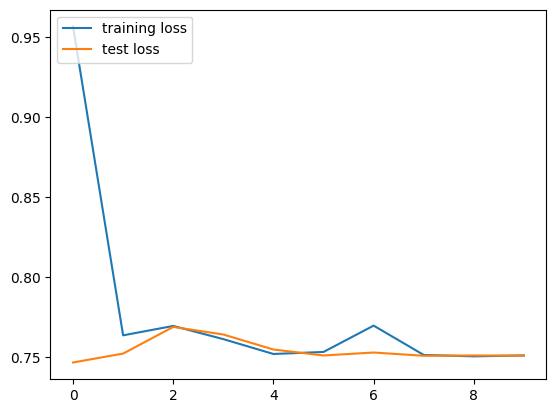

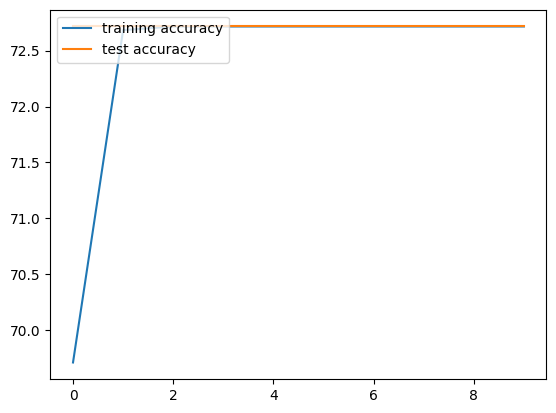

balanced accuracy score: 0.3333333333333333
f1 score: [0.         0.         0.84202655]
roc auc score: [0.50017538 0.50020016 0.50022202]
precision score: [0.         0.         0.72715531]
recall score: [0. 0. 1.]


/Users/yarik/Downloads/MachineLearning/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
train_metric_nn(train_iter, test_iter, vocab, nn.RNN, embeds, num_layers=2, num_hiddens=200, num_intermid_neutrons=256)

GRU

started epoch 1/10
	batch 20/97, loss: 0.874684727191925
	batch 40/97, loss: 0.8146840736269951
	batch 60/97, loss: 0.7822829241553942
	batch 80/97, loss: 0.7659562271088362
epoch 1/10, train: 0.749700604333091, test: 0.759431491807564
started epoch 2/10
	batch 20/97, loss: 0.7258739978075027
	batch 40/97, loss: 0.6984662555158139
	batch 60/97, loss: 0.6810609176754951
	batch 80/97, loss: 0.6761102613061667
epoch 2/10, train: 0.6860838357320765, test: 0.7619815299805907
started epoch 3/10
	batch 20/97, loss: 0.6519595831632614
	batch 40/97, loss: 0.6470960102975368
	batch 60/97, loss: 0.6469409823417663
	batch 80/97, loss: 0.6428689505904913
epoch 3/10, train: 0.6487765044895644, test: 0.7770589811285746
started epoch 4/10
	batch 20/97, loss: 0.6068153932690621
	batch 40/97, loss: 0.5695823714137077
	batch 60/97, loss: 0.5874123573303223
	batch 80/97, loss: 0.6064805082976819
epoch 4/10, train: 0.6106106067441174, test: 0.7674889407821537
started epoch 5/10
	batch 20/97, loss: 0.546304

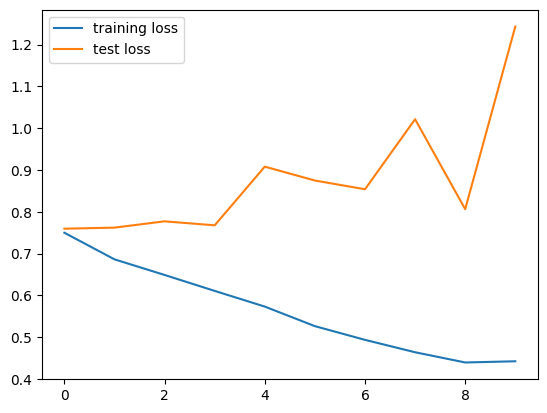

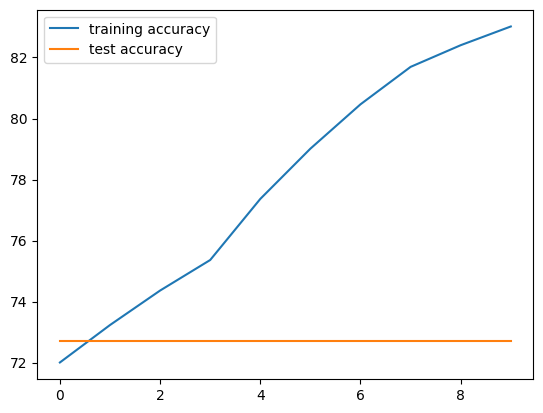

balanced accuracy score: 0.6992114393058341
f1 score: [0.72512648 0.39147803 0.90845361]
roc auc score: [0.97287216 0.87260259 0.93625285]
precision score: [0.61959654 0.96710526 0.84795997]
recall score: [0.87398374 0.24540902 0.97824156]


In [40]:
train_metric_nn(train_iter, test_iter, vocab, nn.GRU, embeds, num_hiddens=100)

LSTM

started epoch 1/10
	batch 20/97, loss: 0.850380951166153
	batch 40/97, loss: 0.787214395403862
	batch 60/97, loss: 0.7743095378081004
	batch 80/97, loss: 0.7585440754890442
epoch 1/10, train: 0.751236695604226, test: 0.745932775674407
started epoch 2/10
	batch 20/97, loss: 0.6985824421048165
	batch 40/97, loss: 0.6888076692819596
	batch 60/97, loss: 0.688845181465149
	batch 80/97, loss: 0.6805296804755926
epoch 2/10, train: 0.6876906159612322, test: 0.7645281307476083
started epoch 3/10
	batch 20/97, loss: 0.6722032353281975
	batch 40/97, loss: 0.6625863827764988
	batch 60/97, loss: 0.6620315725604693
	batch 80/97, loss: 0.6605520326644182
epoch 3/10, train: 0.6532773000677836, test: 0.7076303098619598
started epoch 4/10
	batch 20/97, loss: 0.5719468921422959
	batch 40/97, loss: 0.6261401526629925
	batch 60/97, loss: 0.6285305326183637
	batch 80/97, loss: 0.6267094269394875
epoch 4/10, train: 0.6211277695046258, test: 0.691352808905631
started epoch 5/10
	batch 20/97, loss: 0.564799451

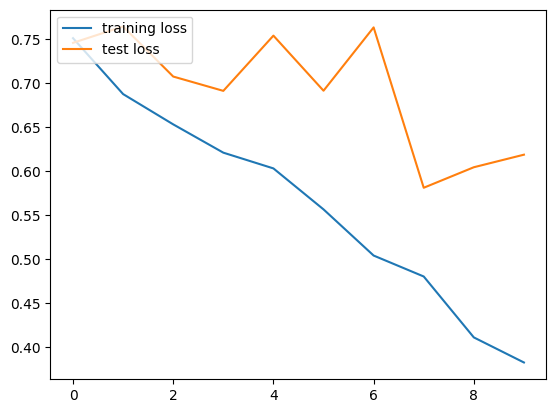

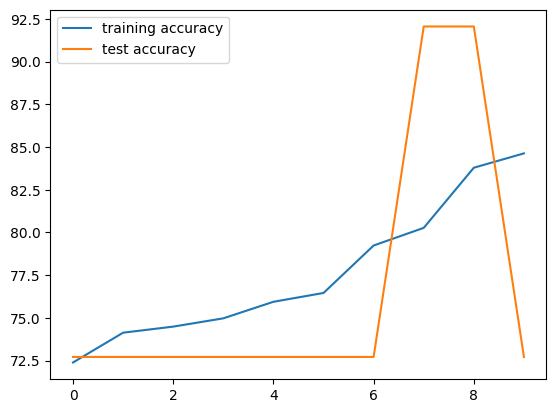

balanced accuracy score: 0.8205472299269113
f1 score: [0.76007678 0.75268817 0.94448102]
roc auc score: [0.98410628 0.88536739 0.96785395]
precision score: [0.72       0.81237911 0.93362256]
recall score: [0.80487805 0.70116861 0.95559503]


In [41]:
train_metric_nn(train_iter, test_iter, vocab, nn.LSTM, embeds, num_hiddens=100, num_intermid_neutrons=100)